# import 

In [300]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import sounddevice as sd
from scipy.io.wavfile import write as wav_write, read as wav_read # Added read for pydub example
import os # For checking file existence

%matplotlib inline

try:
    from midiutil import MIDIFile
    midiutil_available = True
    print("MIDIUtil library found.")
except ImportError:
    print("MIDIUtil library not found. pip install MIDIUtil")
    midiutil_available = False

# Ensure sounddevice defaults (can be set in Session 3 notebook too)
sd.default.samplerate = 44100
sd.default.channels = 1

MIDIUtil library found.


# HAT-P-7 b

violin for high freq and cello for low freq

Processing HAT-P-7 Quarter 4 data...
14
Using 14 data points for MIDI sonification.


/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/3900561286.py:7: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401).remove_outliers(sigma=5)


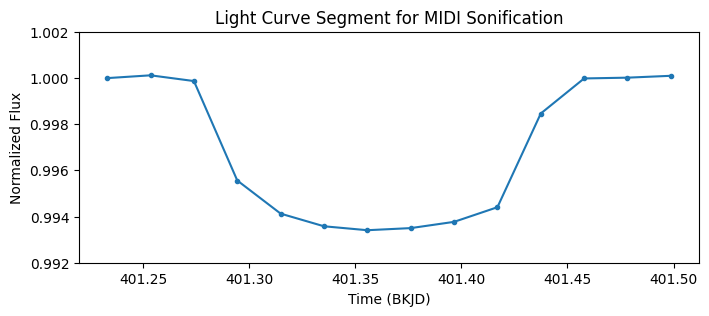

In [301]:
search_result_kepler_q4 = lk.search_lightcurve("HAT-P-7", author="Kepler", cadence="long", quarter = 4)
lc_transit_segment = None # Initialize
print("Processing HAT-P-7 Quarter 4 data...")
# Download the first item from search result by default if not specifying index
lcf_kepler = search_result_kepler_q4.download(quality_bitmask='default') 

lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401).remove_outliers(sigma=5)

transit_center_time_bkjd = 401.368
transit_duration_days = 0.3
time_mask = (lc_processed.time.value > transit_center_time_bkjd - transit_duration_days / 2) & \
            (lc_processed.time.value < transit_center_time_bkjd + transit_duration_days / 2)

lc_transit_segment = lc_processed[time_mask]

print(len(lc_transit_segment.flux))

if lc_transit_segment and len(lc_transit_segment.flux) > 0:
    flux_data = lc_transit_segment.flux.value
    time_data = lc_transit_segment.time.value # These are in BKJD
    print(f"Using {len(flux_data)} data points for MIDI sonification.")
    # Plot for confirmation
    plt.figure(figsize=(8, 3))
    plt.plot(time_data, flux_data, '.-')
    plt.title("Light Curve Segment for MIDI Sonification")
    plt.xlabel("Time (BKJD)")
    plt.ylabel("Normalized Flux")
    plt.ylim(0.992, 1.002)
    plt.show()

In [302]:
if midiutil_available and len(flux_data) > 1:
    # MIDI Parameters
    output_midi_file = "sonified_transit.mid"
    track = 0
    channel = 0
    tempo_bpm = 120  # Beats per minute (determines overall speed)

    # Mapping Parameters
    min_flux_val = np.min(flux_data)
    max_flux_val = np.max(flux_data)
    if min_flux_val == max_flux_val: # Avoid issues if flux is constant
        max_flux_val += 1e-9 # Add a tiny offset to create a range
        
    min_midi_note = 55  # G3
    max_midi_note = 79  # G5 (range of 2 octaves)
    midi_notes = np.interp(flux_data, (min_flux_val, max_flux_val), (min_midi_note, max_midi_note)).astype(int)

    min_velocity = 40  # Quiet
    max_velocity = 100 # Loud
    midi_velocities = np.interp(flux_data, (min_flux_val, max_flux_val), (min_velocity, max_velocity)).astype(int)

    time_min_val = time_data[0]
    time_max_val = time_data[-1]
    
    total_duration_sec_sonification = 10.0
    total_beats = (tempo_bpm / 60.0) * total_duration_sec_sonification
    
    if time_min_val == time_max_val: 
        if len(time_data) > 1:
             note_start_times_beats = np.linspace(0, total_beats if total_beats > 0 else 1.0, len(time_data))
        else: 
             note_start_times_beats = np.array([0.0])
    else:
        note_start_times_beats = np.interp(time_data, (time_min_val, time_max_val), (0, total_beats))

    note_duration_beats = 0.4 

    print(f"Tempo: {tempo_bpm} BPM")
    print(f"MIDI Note Range: {np.min(midi_notes)} - {np.max(midi_notes)}")
    print(f"MIDI Velocity Range: {np.min(midi_velocities)} - {np.max(midi_velocities)}")
    if len(note_start_times_beats) > 0:
        print(f"Note Start Time Range (beats): {note_start_times_beats[0]:.2f} - {note_start_times_beats[-1]:.2f}")
    print(f"Note Duration (beats): {note_duration_beats}")
elif not midiutil_available:
    print("MIDIUtil not available, skipping MIDI parameter definition.")
else: 
    print("Not enough data points (or flux_data not properly defined) for MIDI sonification, skipping MIDI parameter definition.")

Tempo: 120 BPM
MIDI Note Range: 55 - 79
MIDI Velocity Range: 40 - 100
Note Start Time Range (beats): 0.00 - 20.00
Note Duration (beats): 0.4


In [303]:
if midiutil_available and 'midi_notes' in locals() and len(midi_notes) > 0: 
    midi_obj = MIDIFile(1)
    midi_obj.addTempo(track, 0, tempo_bpm) 

    for i in range(len(flux_data)):
        pitch = midi_notes[i]
        time_beats = note_start_times_beats[i]
        duration = note_duration_beats
        velocity = midi_velocities[i]
        if pitch >= 67:
            instrument = 40
            channel = 1
        else:
            instrument = 42
            channel = 0
        if time_beats == 0:
            midi_obj.addProgramChange(track, channel, 0, instrument)
        midi_obj.addNote(track, channel, pitch, time_beats, duration, velocity)

    try:
        with open(output_midi_file, "wb") as f:
            midi_obj.writeFile(f)
        print(f"MIDI file saved as: {output_midi_file}")
        print("You can now play this file using a MIDI player (e.g., QuickTime, GarageBand, online sequencer).")
    except Exception as e:
        print(f"Error writing MIDI file: {e}")
elif not midiutil_available:
    print("MIDIUtil not available, skipping MIDI file creation.")
else:
    print("Not enough data or MIDI parameters not defined, skipping MIDI file creation.")

MIDI file saved as: sonified_transit.mid
You can now play this file using a MIDI player (e.g., QuickTime, GarageBand, online sequencer).


# Kepler-10 b

woodwind instruments and inverted the frequency mapping

Processing Kepler-10 Quarter 1 data...
Light curve processed.
15
Using 15 data points for MIDI sonification.


/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/1282814284.py:7: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49).remove_outliers(sigma=5)


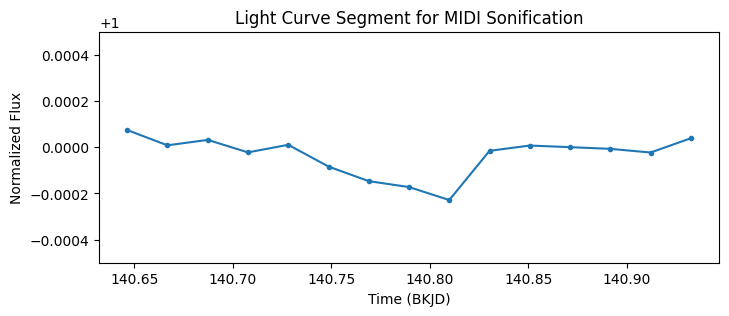

In [304]:
search_result_kepler_q1 = lk.search_lightcurve("Kepler-10", author="Kepler", cadence="long", quarter = 1)
lc_transit_segment = None # Initialize
print("Processing Kepler-10 Quarter 1 data...")
# Download the first item from search result by default if not specifying index
lcf_kepler = search_result_kepler_q1.download(quality_bitmask='default') 

lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49).remove_outliers(sigma=5)
print("Light curve processed.")


transit_center_time_bkjd = 140.7869
transit_duration_days = 0.3

time_mask = (lc_processed.time.value > transit_center_time_bkjd - transit_duration_days / 2) & (lc_processed.time.value < transit_center_time_bkjd + transit_duration_days / 2)
lc_transit_segment = lc_processed[time_mask]
print(len(lc_transit_segment.time))

if lc_transit_segment and len(lc_transit_segment.flux) > 0:
    flux_data = lc_transit_segment.flux.value
    time_data = lc_transit_segment.time.value # These are in BKJD
    print(f"Using {len(flux_data)} data points for MIDI sonification.")
    # Plot for confirmation
    plt.figure(figsize=(8, 3))
    plt.plot(time_data, flux_data, '.-')
    plt.title("Light Curve Segment for MIDI Sonification")
    plt.xlabel("Time (BKJD)")
    plt.ylabel("Normalized Flux")
    plt.ylim(0.9995, 1.0005)
    plt.show()

In [305]:
if midiutil_available and len(flux_data) > 1:
    # MIDI Parameters
    output_midi_file = "sonified_transit.mid"
    track = 0
    channel = 0
    tempo_bpm = 120  # Beats per minute (determines overall speed)

    # Mapping Parameters
    min_flux_val = np.min(flux_data)
    max_flux_val = np.max(flux_data)
    if min_flux_val == max_flux_val: # Avoid issues if flux is constant
        max_flux_val += 1e-9 # Add a tiny offset to create a range
        
    min_midi_note = 55  # G3
    max_midi_note = 79  # G5 (range of 2 octaves)
    midi_notes = np.interp(flux_data, (min_flux_val, max_flux_val), (max_midi_note, min_midi_note)).astype(int) #i inverted this

    min_velocity = 40  # Quiet
    max_velocity = 100 # Loud
    midi_velocities = np.interp(flux_data, (min_flux_val, max_flux_val), (max_velocity, min_velocity)).astype(int) #i inverted this

    time_min_val = time_data[0]
    time_max_val = time_data[-1]
    
    total_duration_sec_sonification = 10.0
    total_beats = (tempo_bpm / 60.0) * total_duration_sec_sonification
    
    if time_min_val == time_max_val: 
        if len(time_data) > 1:
             note_start_times_beats = np.linspace(0, total_beats if total_beats > 0 else 1.0, len(time_data))
        else: 
             note_start_times_beats = np.array([0.0])
    else:
        note_start_times_beats = np.interp(time_data, (time_min_val, time_max_val), (0, total_beats))

    note_duration_beats = 0.4 

    print(f"Tempo: {tempo_bpm} BPM")
    print(f"MIDI Note Range: {np.min(midi_notes)} - {np.max(midi_notes)}")
    print(f"MIDI Velocity Range: {np.min(midi_velocities)} - {np.max(midi_velocities)}")
    if len(note_start_times_beats) > 0:
        print(f"Note Start Time Range (beats): {note_start_times_beats[0]:.2f} - {note_start_times_beats[-1]:.2f}")
    print(f"Note Duration (beats): {note_duration_beats}")
elif not midiutil_available:
    print("MIDIUtil not available, skipping MIDI parameter definition.")
else: 
    print("Not enough data points (or flux_data not properly defined) for MIDI sonification, skipping MIDI parameter definition.")

Tempo: 120 BPM
MIDI Note Range: 55 - 79
MIDI Velocity Range: 40 - 100
Note Start Time Range (beats): 0.00 - 20.00
Note Duration (beats): 0.4


In [306]:
if midiutil_available and 'midi_notes' in locals() and len(midi_notes) > 0: 
    midi_obj = MIDIFile(1)
    midi_obj.addTempo(track, 0, tempo_bpm) 

    for i in range(len(flux_data)):
        pitch = midi_notes[i]
        time_beats = note_start_times_beats[i]
        duration = note_duration_beats
        velocity = midi_velocities[i]
        if pitch >= 67:
            instrument = 73
            channel = 1
        else:
            instrument = 70
            channel = 0
        if time_beats == 0:
            midi_obj.addProgramChange(track, channel, 0, instrument)
        midi_obj.addNote(track, channel, pitch, time_beats, duration, velocity)


    try:
        with open(output_midi_file, "wb") as f:
            midi_obj.writeFile(f)
        print(f"MIDI file saved as: {output_midi_file}")
        print("You can now play this file using a MIDI player (e.g., QuickTime, GarageBand, online sequencer).")
    except Exception as e:
        print(f"Error writing MIDI file: {e}")
elif not midiutil_available:
    print("MIDIUtil not available, skipping MIDI file creation.")
else:
    print("Not enough data or MIDI parameters not defined, skipping MIDI file creation.")

MIDI file saved as: sonified_transit.mid
You can now play this file using a MIDI player (e.g., QuickTime, GarageBand, online sequencer).


# KOI-94

long note durations for high flux, short note durations for low flux

Processing HAT-P-7 Quarter 4 data...
23
Using 23 data points for MIDI sonification.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/2654213093.py:7: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401)


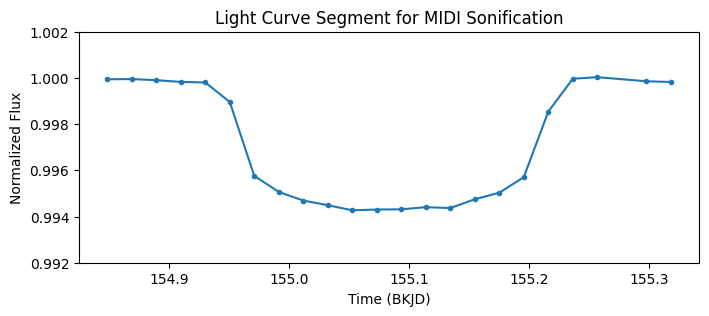

In [ ]:
search_result_kepler_q1 = lk.search_lightcurve("KOI-94", author="Kepler", cadence="long", quarter = 1)
lc_transit_segment = None # Initialize
print("Processing KOI-94 Quarter 1 data...")
# Download the first item from search result by default if not specifying index
lcf_kepler = search_result_kepler_q1.download(quality_bitmask='default') 

lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401)

transit_center_time_bkjd = 155.08
transit_duration_days = 0.5
time_mask = (lc_processed.time.value > transit_center_time_bkjd - transit_duration_days / 2) & \
            (lc_processed.time.value < transit_center_time_bkjd + transit_duration_days / 2)

lc_transit_segment = lc_processed[time_mask]

print(len(lc_transit_segment.flux))

if lc_transit_segment and len(lc_transit_segment.flux) > 0:
    flux_data = lc_transit_segment.flux.value
    time_data = lc_transit_segment.time.value # These are in BKJD
    print(f"Using {len(flux_data)} data points for MIDI sonification.")
    # Plot for confirmation
    plt.figure(figsize=(8, 3))
    plt.plot(time_data, flux_data, '.-')
    plt.title("Light Curve Segment for MIDI Sonification")
    plt.xlabel("Time (BKJD)")
    plt.ylabel("Normalized Flux")
    plt.ylim(0.992, 1.002)
    plt.show()

In [308]:
if midiutil_available and len(flux_data) > 1:
    # MIDI Parameters
    output_midi_file = "sonified_transit.mid"
    track = 0
    channel = 0
    tempo_bpm = 120  # Beats per minute (determines overall speed)

    # Mapping Parameters
    min_flux_val = np.min(flux_data)
    max_flux_val = np.max(flux_data)
    if min_flux_val == max_flux_val: # Avoid issues if flux is constant
        max_flux_val += 1e-9 # Add a tiny offset to create a range
        
    min_midi_note = 55  # G3
    max_midi_note = 79  # G5 (range of 2 octaves)
    midi_notes = np.interp(flux_data, (min_flux_val, max_flux_val), (min_midi_note, max_midi_note)).astype(int)

    #instead of velocity, adding note duration
    min_duration = 0.125  # Short
    max_duration = 4 # Long
    midi_durations = np.interp(flux_data, (min_flux_val, max_flux_val), (min_duration, max_duration)) #no int

    time_min_val = time_data[0]
    time_max_val = time_data[-1]
    
    total_duration_sec_sonification = 10.0
    total_beats = (tempo_bpm / 60.0) * total_duration_sec_sonification
    
    if time_min_val == time_max_val: 
        if len(time_data) > 1:
              note_start_times_beats = np.linspace(0, total_beats if total_beats > 0 else 1.0, len(time_data))
        else: 
              note_start_times_beats = np.array([0.0])
    else:
        note_start_times_beats = np.interp(time_data, (time_min_val, time_max_val), (0, total_beats))

    note_duration_beats = 0.4 


    print(f"Tempo: {tempo_bpm} BPM")
    print(f"MIDI Note Range: {np.min(midi_notes)} - {np.max(midi_notes)}")
    if len(note_start_times_beats) > 0:
        print(f"Note Start Time Range (beats): {note_start_times_beats[0]:.2f} - {note_start_times_beats[-1]:.2f}")
    print(f"Note Duration (beats): {note_duration_beats}")
elif not midiutil_available:
    print("MIDIUtil not available, skipping MIDI parameter definition.")
else: 
    print("Not enough data points (or flux_data not properly defined) for MIDI sonification, skipping MIDI parameter definition.")

Tempo: 120 BPM
MIDI Note Range: 55 - 79
Note Start Time Range (beats): 0.00 - 20.00
Note Duration (beats): 0.4


In [309]:
if midiutil_available and 'midi_notes' in locals() and len(midi_notes) > 0: 
    midi_obj = MIDIFile(1)
    midi_obj.addTempo(track, 0, tempo_bpm) 

    for i in range(len(flux_data)):
        pitch = midi_notes[i]
        time_beats = note_start_times_beats[i]
        duration = midi_durations[i]
        midi_obj.addProgramChange(track, channel, time=0, program=49)
        midi_obj.addNote(track, channel, pitch, time_beats, duration, 100)

    try:
        with open(output_midi_file, "wb") as f:
            midi_obj.writeFile(f)
        print(f"MIDI file saved as: {output_midi_file}")
        print("You can now play this file using a MIDI player (e.g., QuickTime, GarageBand, online sequencer).")
    except Exception as e:
        print(f"Error writing MIDI file: {e}")
elif not midiutil_available:
    print("MIDIUtil not available, skipping MIDI file creation.")
else:
    print("Not enough data or MIDI parameters not defined, skipping MIDI file creation.")

MIDI file saved as: sonified_transit.mid
You can now play this file using a MIDI player (e.g., QuickTime, GarageBand, online sequencer).
